<a href="https://colab.research.google.com/github/nattntn/PMU-B-PersonalAI/blob/main/Test_Hack_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##เรียกใช้ CSV

In [1]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import

In [2]:
import os
import numpy as np
import pandas as pd
#import efficientnet.tfkeras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Clone Efficient

In [3]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


# Load Model

In [4]:
import sys
sys.path.append('/content/gdrive/MyDrive/Hackathon/Model/Freeze_R1.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})


In [5]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Hackathon/Model/Freeze_R1.h5")
model.summary()

Model: "EffNet_skin"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normalizatio

In [6]:
height = width = model.input_shape[1]
print(f"height: {height}, width: {width}")

height: 224, width: 224


# Data Preparation

In [7]:
train = pd.read_csv(r'/content/gdrive/MyDrive/Hackathon/Table_train.csv')
train

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,1141,HAM_0003290,ISIC_0031735,df,histo,80.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,12,HAM_0004234,ISIC_0025984,bkl,histo,85.0,female,chest,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,2414,HAM_0004097,ISIC_0025677,vasc,consensus,50.0,female,abdomen,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,36,HAM_0000351,ISIC_0029559,bkl,histo,85.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,3066,HAM_0005858,ISIC_0028879,nv,follow_up,55.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...,...
639,9776,HAM_0005389,ISIC_0024372,akiec,histo,70.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
640,2429,HAM_0006193,ISIC_0029877,vasc,consensus,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
641,2471,HAM_0002134,ISIC_0024431,bcc,histo,45.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
642,2980,HAM_0001940,ISIC_0028502,nv,follow_up,45.0,female,abdomen,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


In [8]:
train = train.iloc[:,1:]

In [9]:
DATA_PATH = "/content/gdrive/MyDrive/Hackathon/Skin Cancer/Skin Cancer"
os.chdir(DATA_PATH)
# train_dir = os.path.join(DATA_PATH, 'Normal')
# print(train_dir)
# test_dir = os.path.join(DATA_PATH, 'Test')
# print(test_dir)

In [23]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'dx',
        class_mode = 'categorical',
        color_mode= 'rgb',
        target_size=(height, width),# รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        batch_size=batch_size)
#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 644 validated image filenames belonging to 7 classes.
{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [11]:
test = pd.read_csv (r'/content/gdrive/MyDrive/Hackathon/Table_test.csv')
test

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,2348,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,1258,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,2547,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,2495,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,1300,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...,...
75,2523,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
76,1199,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
77,109,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
78,1131,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


In [12]:
test = test.iloc[:,1:]
test

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...
75,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
76,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
77,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
78,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


# Predict

In [13]:
model.output_names

['Prediction_Dis']

In [14]:
act = test['dx'].tolist() #ค่าจริง
path = test['Path_Name'].tolist() #path

In [24]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])

    return result[0]

In [25]:
predict_image(path[0])

1/1 [==============================] - 0s 43ms/step


array([1.7352963e-06, 1.8399036e-05, 6.3337420e-06, 2.3044749e-05,
       1.7849405e-04, 1.6696580e-05, 9.9975532e-01], dtype=float32)

In [26]:
#Predict
pred_list = list()
prob_list = list()
pred_Re = list()

for i in range(0,len(path)):
    predict = predict_image(path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    pred_Re.append(result)
    prob_list.append(predict[result])

1/1 [==============================] - 0s 24ms/step


In [27]:
pred_list

['vasc',
 'mel',
 'bcc',
 'df',
 'bkl',
 'df',
 'df',
 'bcc',
 'vasc',
 'nv',
 'vasc',
 'bcc',
 'df',
 'mel',
 'df',
 'akiec',
 'mel',
 'vasc',
 'bcc',
 'bcc',
 'mel',
 'bkl',
 'bkl',
 'nv',
 'bkl',
 'mel',
 'nv',
 'nv',
 'vasc',
 'vasc',
 'mel',
 'bcc',
 'mel',
 'bcc',
 'akiec',
 'df',
 'df',
 'vasc',
 'vasc',
 'bcc',
 'mel',
 'nv',
 'mel',
 'mel',
 'mel',
 'vasc',
 'mel',
 'akiec',
 'df',
 'vasc',
 'bkl',
 'akiec',
 'bkl',
 'df',
 'bkl',
 'nv',
 'mel',
 'nv',
 'akiec',
 'mel',
 'bcc',
 'nv',
 'df',
 'nv',
 'vasc',
 'bcc',
 'mel',
 'nv',
 'df',
 'mel',
 'nv',
 'bkl',
 'nv',
 'vasc',
 'bkl',
 'bcc',
 'df',
 'mel',
 'df',
 'bcc']

In [28]:
prob_list

[0.9997553,
 0.9829785,
 0.47003093,
 0.6074094,
 0.5592995,
 0.89391714,
 0.6983447,
 0.4847484,
 0.4311325,
 0.9397959,
 0.99160564,
 0.73749524,
 0.42835623,
 0.7953347,
 0.89878273,
 0.48916754,
 0.9527034,
 0.9999987,
 0.6037759,
 0.9974782,
 0.4435193,
 0.99952734,
 0.58610183,
 0.9957152,
 0.8991042,
 0.9902379,
 0.998934,
 0.997895,
 0.7666097,
 0.9995833,
 0.9689474,
 0.9994031,
 0.8089799,
 0.8942034,
 0.6026827,
 0.98028046,
 0.9485595,
 0.9997414,
 0.99996066,
 0.63314253,
 0.999913,
 0.99978536,
 0.50611174,
 0.9999765,
 0.73115665,
 0.6172558,
 0.88632846,
 0.75483376,
 0.39140806,
 0.99808395,
 0.57286286,
 0.9245547,
 0.7667037,
 0.9681741,
 0.7554212,
 0.9896528,
 0.6499555,
 0.9884276,
 0.6928529,
 0.91930676,
 0.9274772,
 0.9555676,
 0.62758917,
 0.9999982,
 0.9989825,
 0.9974177,
 0.9965706,
 0.9957689,
 0.9864986,
 0.68781173,
 0.99983037,
 0.99968505,
 0.9949856,
 0.9997924,
 0.98393005,
 0.980075,
 0.8424394,
 0.53736347,
 0.9860774,
 0.99481493]

# Prediction

In [29]:
prob_list

[0.9997553,
 0.9829785,
 0.47003093,
 0.6074094,
 0.5592995,
 0.89391714,
 0.6983447,
 0.4847484,
 0.4311325,
 0.9397959,
 0.99160564,
 0.73749524,
 0.42835623,
 0.7953347,
 0.89878273,
 0.48916754,
 0.9527034,
 0.9999987,
 0.6037759,
 0.9974782,
 0.4435193,
 0.99952734,
 0.58610183,
 0.9957152,
 0.8991042,
 0.9902379,
 0.998934,
 0.997895,
 0.7666097,
 0.9995833,
 0.9689474,
 0.9994031,
 0.8089799,
 0.8942034,
 0.6026827,
 0.98028046,
 0.9485595,
 0.9997414,
 0.99996066,
 0.63314253,
 0.999913,
 0.99978536,
 0.50611174,
 0.9999765,
 0.73115665,
 0.6172558,
 0.88632846,
 0.75483376,
 0.39140806,
 0.99808395,
 0.57286286,
 0.9245547,
 0.7667037,
 0.9681741,
 0.7554212,
 0.9896528,
 0.6499555,
 0.9884276,
 0.6928529,
 0.91930676,
 0.9274772,
 0.9555676,
 0.62758917,
 0.9999982,
 0.9989825,
 0.9974177,
 0.9965706,
 0.9957689,
 0.9864986,
 0.68781173,
 0.99983037,
 0.99968505,
 0.9949856,
 0.9997924,
 0.98393005,
 0.980075,
 0.8424394,
 0.53736347,
 0.9860774,
 0.99481493]

In [30]:
pred_arr = np.array(pred_list) #แปลงเป็น array
act_arr = np.array(act)

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_arr, pred_arr)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_arr, pred_arr))#performance

classifier accuracy = 76.25%
              precision    recall  f1-score   support

       akiec       1.00      0.42      0.59        12
         bcc       0.75      0.75      0.75        12
         bkl       0.78      0.64      0.70        11
          df       0.69      0.82      0.75        11
         mel       0.53      0.82      0.64        11
          nv       0.92      0.92      0.92        12
        vasc       0.92      1.00      0.96        11

    accuracy                           0.76        80
   macro avg       0.80      0.77      0.76        80
weighted avg       0.80      0.76      0.76        80



Text(0.5, 76.24999999999999, 'Predicted label')

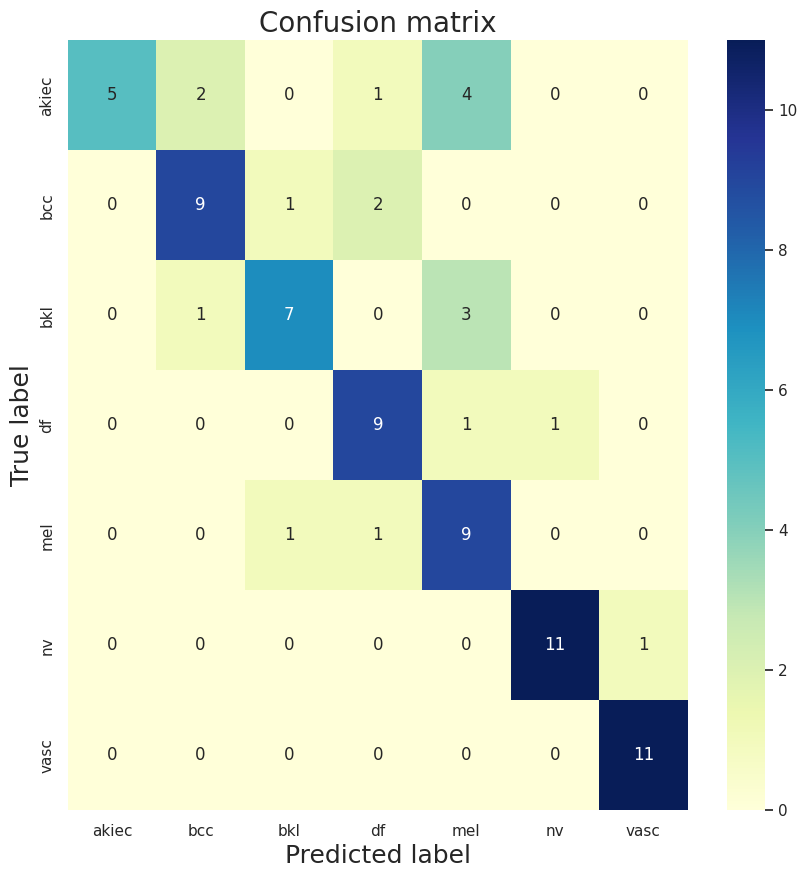

In [32]:
#create CF
data = {'Actual': act_arr,'Predicted' : pred_arr,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_arr, pred_arr)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

# ตารางรวม

In [33]:
test

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name
0,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
1,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
2,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
3,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
4,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
...,...,...,...,...,...,...,...,...
75,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
76,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
77,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...
78,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...


In [34]:
#Regression
test['Predict'] = pred_list # ผลที่ทำนาย
test['Prob'] = prob_list

In [46]:
test['Pre_int'] = pred_Re

In [42]:
labels

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

In [43]:
import pandas as pd

# Assuming your DataFrame is named df
# Replace df with the actual name of your DataFrame if different

# Create a dictionary to map disease names to category names
disease_to_category = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'mel': 4,
    'nv': 5,
    'vasc': 6,
    # Add more mappings as needed
}

# Map the values in the "Disease" column to the corresponding categories
test['label_dx'] = test['dx'].map(disease_to_category)

# Display the updated DataFrame
print(test)


      lesion_id      image_id    dx    dx_type   age     sex     localization  \
0   HAM_0003771  ISIC_0026163  vasc      histo  50.0  female             hand   
1   HAM_0004720  ISIC_0028642   mel      histo  40.0    male  lower extremity   
2   HAM_0002717  ISIC_0031284   bcc      histo  75.0    male             face   
3   HAM_0004871  ISIC_0030261   bcc      histo  70.0    male             back   
4   HAM_0006521  ISIC_0025155   mel      histo  80.0    male  lower extremity   
..          ...           ...   ...        ...   ...     ...              ...   
75  HAM_0005309  ISIC_0026282   bcc      histo  50.0    male  upper extremity   
76  HAM_0002848  ISIC_0027598    df  consensus  60.0  female  lower extremity   
77  HAM_0001417  ISIC_0032382   bkl      histo  55.0    male             face   
78  HAM_0002706  ISIC_0025954    df      histo  40.0    male  lower extremity   
79  HAM_0000195  ISIC_0028495   bcc      histo  50.0  female             back   

                           

In [47]:
test

,lesion_id,image_id,dx,dx_type,age,sex,localization,Path_Name,Predict,Prob,Act_int,label_dx,Pre_int
0,HAM_0003771,ISIC_0026163,vasc,histo,50.0,female,hand,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,vasc,0.999755,6,6,6
1,HAM_0004720,ISIC_0028642,mel,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,mel,0.982979,4,4,4
2,HAM_0002717,ISIC_0031284,bcc,histo,75.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,bcc,0.470031,1,1,1
3,HAM_0004871,ISIC_0030261,bcc,histo,70.0,male,back,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,df,0.607409,3,1,3
4,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,bkl,0.559300,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,HAM_0005309,ISIC_0026282,bcc,histo,50.0,male,upper extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,bcc,0.980075,1,1,1
76,HAM_0002848,ISIC_0027598,df,consensus,60.0,female,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,df,0.842439,3,3,3
77,HAM_0001417,ISIC_0032382,bkl,histo,55.0,male,face,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,mel,0.537363,4,2,4
78,HAM_0002706,ISIC_0025954,df,histo,40.0,male,lower extremity,/content/gdrive/MyDrive/Hackathon/Skin Cancer/...,df,0.986077,3,3,3
